### Risk-On/Off Trading Strategy
- Risk-On: 저퀄리티 채권/위험자산 매수
- Risk-Off: 고퀄리티 채권 매수

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


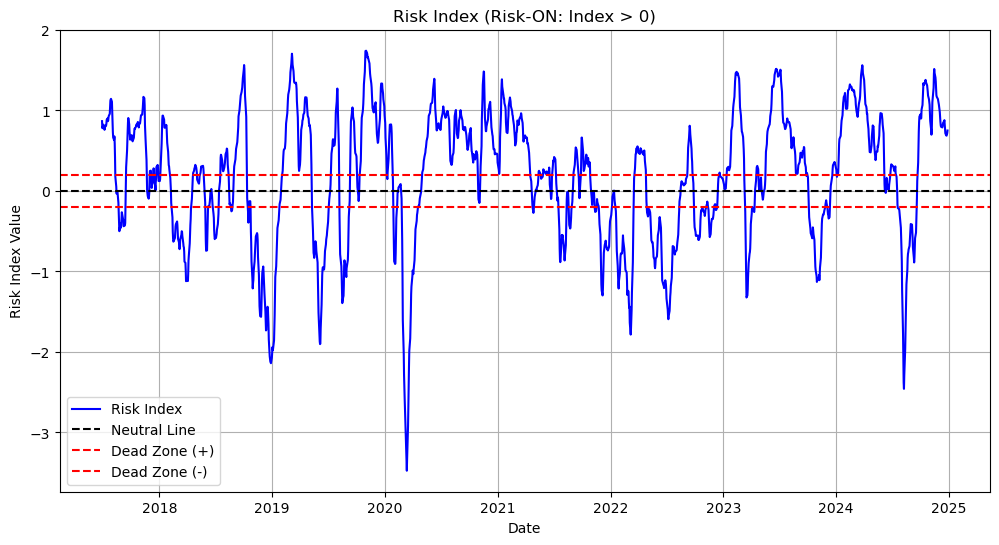

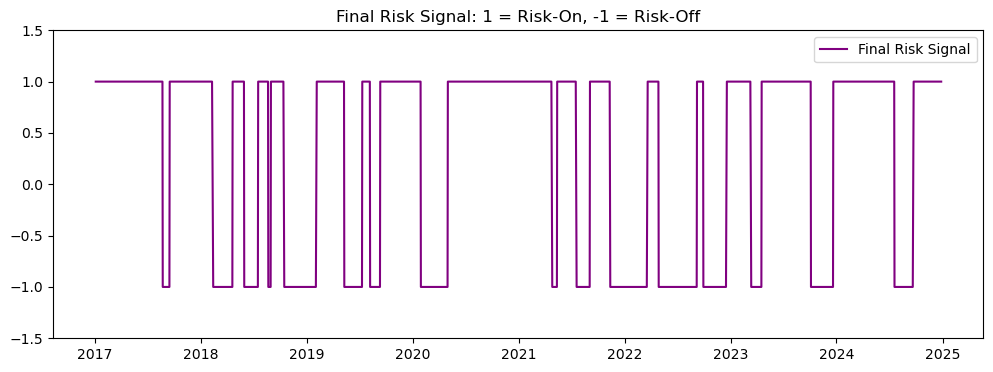

In [180]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import vectorbt as vbt

# --- Parameters ---
start_date = "2017-01-01"
end_date = "2024-12-28"
window_long = 60
dead_zone = 0.2

#FRED API키
api_key = "5ac724748f08e2b7210dde20f7880a42"

# --- FRED 데이터 로드 ---
fred_codes = {
    "AAA_Yield": "BAMLC0A1CAAAEY",   # AAA 등급 회사채 금리
    "BBB_Yield": "BAMLC0A4CBBBEY",    # BBB 등급 회사채 금리
    "Yield_Curve": "T10Y2Y",          # 10년물 - 2년물 금리스프레드
    "DGS10": "DGS10"                 # 10년물 미국채 수익률
}

fred_data = web.DataReader(list(fred_codes.values()), "fred", start=start_date, end=end_date, api_key=api_key)

fred_data.columns = fred_codes.keys()


# 신용스프레드 계산 (BBB - AAA)
fred_data['Credit_Spread'] = fred_data['BBB_Yield'] - fred_data['AAA_Yield']

# ICE BofAML MOVE 지수를 사용 (티커 '^MOVE)
move = yf.download('^MOVE', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('MOVE')

# USD/JPY 데이터 ('JPY=X')
usd_jpy = yf.download('JPY=X', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('USDJPY')

# S&P500 데이터
sp500 = yf.download('^GSPC', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('SP500')


df_risk = pd.concat([fred_data[['Credit_Spread', 'Yield_Curve', 'DGS10']], move, usd_jpy, sp500], axis=1).dropna()
df_risk = df_risk.dropna()

# (1) 신용스프레드 z-점수: 스프레드가 높으면(즉, BBB - AAA가 크면) 리스크오프
df_risk['Credit_z'] = (df_risk['Credit_Spread'] - df_risk['Credit_Spread'].rolling(window_long).mean()) \
                      / df_risk['Credit_Spread'].rolling(window_long).std()

# (2) MOVE z-점수: MOVE 지수가 높으면(즉, 채권 변동성이 높으면) 리스크오프
df_risk['MOVE_z'] = (df_risk['MOVE'] - df_risk['MOVE'].rolling(window_long).mean()) \
                    / df_risk['MOVE'].rolling(window_long).std()

# (3) 10년물 금리 모멘텀: 10년물 금리의 일별 변화량을 측정하여, 급격한 금리 하락(안전자산 선호)을 리스크오프로 판단
Yield_ma = df_risk['DGS10'].rolling(window=window_long).mean()
df_risk['DGS10_diff'] = df_risk['DGS10'] - Yield_ma
df_risk['DGS10_change_z'] = (df_risk['DGS10_diff'] - df_risk['DGS10_diff'].rolling(window_long).mean()) \
                         / df_risk['DGS10_diff'].rolling(window_long).std()

# df_risk['DGS10_change'] = df_risk['DGS10'].diff()
# df_risk['DGS10_change_z'] = (df_risk['DGS10_change'] - df_risk['DGS10_change'].rolling(window_long).mean()) \
#                             / df_risk['DGS10_change'].rolling(window_long).std()
# 금리 하락(음의 변화)은 위험회피 상황이므로, -1을 곱해 높은 값이 리스크오프로 반영되도록 함.
df_risk['YieldMomentum_z'] = -1 * df_risk['DGS10_change_z']

# (4) USD/JPY 안전자산 지표  
# 위험 회피 시 투자자들이 안전자산인 엔을 선호하여 USD/JPY가 하락함 → 이동평균보다 낮으면 리스크오프로 판단
usd_jpy_ma = df_risk['USDJPY'].rolling(window=window_long).mean()
df_risk['USDJPY_MA_diff'] = df_risk['USDJPY'] - usd_jpy_ma
df_risk['USDJPY_MA_z'] = (df_risk['USDJPY_MA_diff'] - df_risk['USDJPY_MA_diff'].rolling(window_long).mean()) \
                         / df_risk['USDJPY_MA_diff'].rolling(window_long).std()
# USD/JPY가 이동평균보다 낮으면, USDJPY_MA_diff는 음수가 되고 이를 -1로 곱해 양수로 만들어 리스크오프 신호로 반영
df_risk['USDJPY_MA_z'] = -1 * df_risk['USDJPY_MA_z']

# (5) S&P500 지수 지표
df_risk['SP500_z'] = (df_risk['SP500'] - df_risk['SP500'].rolling(window_long).mean()) \
                    / df_risk['SP500'].rolling(window_long).std()

df_risk['SP500_z'] = -1 * df_risk['SP500_z']

# Construct the Composite Risk Indicator
# 가중치 설정 (신용 0.30, MOVE 0.25, 금리 모멘텀 0.25, USD/JPY 0.20)
w_credit = 0.20
w_move = 0.20
w_yield = 0.20
w_usdjpy = 0.20
w_sp500 = 0.20

df_risk['Composite'] = (w_credit * df_risk['Credit_z'] +
                        w_move * df_risk['MOVE_z'] +
                        w_yield * df_risk['YieldMomentum_z'] +
                        w_usdjpy * df_risk['USDJPY_MA_z'] +
                        w_sp500*df_risk['SP500_z'])
# 5일 단순 이동평균으로 스무딩
df_risk['Composite_Smoothed'] = df_risk['Composite'].rolling(window=5, min_periods=1).mean()

# -- Risk Signal 생성 --
# Composite_Smoothed > 0이면 리스크 오프(-1), 아니면 리스크 온(1)
df_risk['Raw_Signal'] = np.where(df_risk['Composite_Smoothed'] > 0, -1, 1)
# Dead Zone 내에서는 이전 신호 유지
final_signals = df_risk['Raw_Signal'].copy()
for i in range(1, len(final_signals)):
    if abs(df_risk['Composite_Smoothed'].iat[i]) < dead_zone:
        final_signals.iat[i] = final_signals.iat[i-1]
df_risk['Final_Signal'] = np.where(final_signals >= 0, 1, -1)

# 거래 진입은 2일 래그 (예: 화요일 데이터 → 목요일 거래)
df_risk['Trade_Signal'] = df_risk['Final_Signal'].shift(2)

# ================================
# 2-2) 별도의 MOVE 포지션 축소 신호 생성
# ================================
# 30일 이동평균/표준편차 기반 z‑score 계산 후, 1일 래그 (어제 데이터 사용)
move_ma_30 = df_risk['MOVE'].rolling(window=30).mean()
move_std_30 = df_risk['MOVE'].rolling(window=30).std()
move_z = (df_risk['MOVE'] - move_ma_30) / move_std_30
move_z_lag1 = move_z
# 조건: move_z_lag1 > 0.7이면 포지션 축소 필요 → -1, 아니면 풀 포지션 → 1
df_risk['Move_Signal_Raw'] = np.where(move_z_lag1 > 1.0, 1, 1)

# 매주 **수요일**(weekday==2)에 MOVE 신호 업데이트 후 forward fill하여 그 주 내내 유지
df_risk['Weekly_Move_Signal'] = df_risk.loc[df_risk.index.weekday == 2, 'Move_Signal_Raw'] \
                                .reindex(df_risk.index, method='ffill')

# (참고: 원한다면 최종 포지션 계산 시 아래와 같이 두 신호를 함께 사용할 수 있음)
# df_risk['Final_Position'] = df_risk['Trade_Signal']  # + 별도 MOVE 신호 참고 등
# --- 결과 플롯 ---
plt.figure(figsize=(12,6))
plt.plot(df_risk.index, -df_risk['Composite_Smoothed'], label='Risk Index', color='blue')
plt.axhline(0, color='black', linestyle='--', label="Neutral Line")
plt.axhline(dead_zone, color='red', linestyle='--', label="Dead Zone (+)")
plt.axhline(-dead_zone, color='red', linestyle='--', label="Dead Zone (-)")
plt.title("Risk Index (Risk-ON: Index > 0)")
plt.xlabel("Date")
plt.ylabel("Risk Index Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_risk.index, df_risk['Final_Signal'], label='Final Risk Signal', color='purple')
plt.title("Final Risk Signal: 1 = Risk-On, -1 = Risk-Off")
plt.ylim([-1.5, 1.5])
plt.legend()
plt.show()


In [181]:
df_risk

,Credit_Spread,Yield_Curve,DGS10,MOVE,USDJPY,SP500,Credit_z,MOVE_z,DGS10_diff,DGS10_change_z,...,USDJPY_MA_diff,USDJPY_MA_z,SP500_z,Composite,Composite_Smoothed,Raw_Signal,Final_Signal,Trade_Signal,Move_Signal_Raw,Weekly_Move_Signal
2017-01-03,0.75,1.23,2.45,76.730003,117.495003,2257.830078,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,NaN,1,NaN
2017-01-04,0.75,1.22,2.46,76.410004,117.658997,2270.750000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,NaN,1,1.0
2017-01-05,0.75,1.20,2.37,76.500000,117.112999,2269.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1.0,1,1.0
2017-01-06,0.74,1.20,2.42,75.239998,115.264999,2276.979980,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1.0,1,1.0
2017-01-09,0.74,1.17,2.38,74.830002,117.150002,2268.899902,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,0.61,0.22,4.52,91.750000,157.643997,5930.850098,-1.038738,-0.935033,0.308167,0.437399,...,6.487797,-0.890382,-0.334362,-0.727183,-0.715917,1,1,1.0,1,1.0
2024-12-23,0.61,0.29,4.59,95.849998,156.533005,5974.069824,-1.009726,-0.692019,0.364833,0.729714,...,5.150638,-0.501161,-0.654739,-0.717472,-0.688656,1,1,1.0,1,1.0
2024-12-24,0.61,0.30,4.59,96.949997,157.164993,6040.040039,-0.982232,-0.635476,0.351500,0.630722,...,5.574593,-0.602351,-1.150908,-0.800338,-0.686290,1,1,1.0,1,1.0
2024-12-26,0.61,0.28,4.58,95.199997,157.132996,6037.589844,-0.956282,-0.747549,0.327667,0.463089,...,5.341645,-0.506447,-1.095234,-0.753720,-0.716590,1,1,1.0,1,1.0


In [182]:
d = df_risk['Weekly_Move_Signal']
d

2017-01-03    NaN
2017-01-04    1.0
2017-01-05    1.0
2017-01-06    1.0
2017-01-09    1.0
             ... 
2024-12-20    1.0
2024-12-23    1.0
2024-12-24    1.0
2024-12-26    1.0
2024-12-27    1.0
Name: Weekly_Move_Signal, Length: 1979, dtype: float64

In [183]:
# 원래 주석: high_quality_etfs = ['AGG', 'LQD', 'IEF', 'TLT'], low_quality_etfs = ['HYG', 'JNK', 'EMB', 'HYD']
high_quality_etfs = ['AGG']
low_quality_etfs  = ['QQQ']
etfs = high_quality_etfs + low_quality_etfs

tc_rate = 0.003
# -- ETF 가격 데이터 다운로드 및 전처리 --
price_data = yf.download(etfs, start=start_date, end=end_date, progress=False)['Close']
price_data['HighQuality'] = price_data[high_quality_etfs].mean(axis=1)
price_data['LowQuality']  = price_data[low_quality_etfs].mean(axis=1)
price_data['HQ_Return']   = price_data['HighQuality'].pct_change()
price_data['LQ_Return']   = price_data['LowQuality'].pct_change()

# -- 전략용 데이터 (df_strategy) 생성 --
# 리스크 신호와 별도 MOVE 신호(Weekly_Move_Signal)를 가격 데이터와 병합
df_strategy = price_data[['HQ_Return', 'LQ_Return']].join(
    df_risk[['Final_Signal', 'Weekly_Move_Signal']], how='inner'
)
df_strategy = df_strategy.dropna()

# 주 단위 리밸런싱: pandas의 weekday에서 화요일은 1 (ETF 전략에서는 화요일 신호로 거래 → 목요일 진입)
rebalance_days = df_strategy.index[df_strategy.index.weekday == 1]
rebalance_days = pd.to_datetime(rebalance_days)
weekly_risk_signal = df_strategy.loc[rebalance_days, 'Final_Signal']
df_strategy['Weekly_Risk_Signal'] = weekly_risk_signal.reindex(df_strategy.index, method='ffill')
df_strategy['Risk_Signal'] = df_strategy['Weekly_Risk_Signal'].shift(2)
df_strategy = df_strategy.dropna(subset=['Risk_Signal'])

# --- 별도의 MOVE 신호를 그대로 전달 ---
df_strategy['Move_Signal'] = df_strategy['Weekly_Move_Signal'].shift(1)

# ETF 전략에서는 두 신호를 별도로 활용하여, 예를 들어 MOVE 신호에 따라 주문 비중을 조정합니다.
# 아래에서는 MOVE 신호가 -1이면 감축할 것으로 판단하여 0.3 (감축), 1이면 1.0 (풀 포지션)으로 변환합니다.
df_strategy['Move_Factor'] = np.where(df_strategy['Move_Signal'] == -1, 1.0, 1.0)

# 최종 주문 목표 비중 결정: Risk_Signal이 -1이면 HighQuality, 1이면 LowQuality에 투자하고, MOVE 신호에 따른 주문 크기를 적용
weights = pd.DataFrame(index=df_strategy.index, columns=['HighQuality', 'LowQuality'])
weights['HighQuality'] = np.where(df_strategy['Risk_Signal'] == -1, df_strategy['Move_Factor'], 0.0)
weights['LowQuality']  = np.where(df_strategy['Risk_Signal'] ==  1, df_strategy['Move_Factor'], 0.0)

# ================================
# 4) vectorbt를 이용한 백테스트
# ================================
# 주문 수량 계산: (오늘의 목표 비중 - 전일 목표 비중) / 해당 자산 가격
vecbt_prices = price_data[['HighQuality', 'LowQuality']].loc[df_strategy.index]
diff_weights = weights.diff().fillna(weights)
orders = diff_weights.div(vecbt_prices).fillna(0.0)

pf = vbt.Portfolio.from_orders(
    close=vecbt_prices,
    size=orders,
    init_cash=1.0,
    fees=tc_rate,
    freq='1D',
    cash_sharing=True,
    group_by=[0, 0]
)

print("Portfolio Statistics:")
print(f"Annualized Volatility: {pf.annualized_volatility():.2%}")
print(pf.stats())

Portfolio Statistics:
Annualized Volatility: 21.65%
Start                                 2017-01-12 00:00:00
End                                   2024-12-27 00:00:00
Period                                 1972 days 00:00:00
Start Value                                           1.0
End Value                                        4.259637
Total Return [%]                               325.963741
Benchmark Return [%]                           180.164262
Max Gross Exposure [%]                     2593564.458952
Total Fees Paid                                  0.191453
Max Drawdown [%]                                28.804225
Max Drawdown Duration                   390 days 00:00:00
Total Trades                                           34
Total Closed Trades                                    32
Total Open Trades                                       2
Open Trade PnL                                   1.316564
Win Rate [%]                                        56.25
Best Trade [%]      

In [117]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import vectorbt as vbt


In [166]:
start_date = "2017-01-01"
end_date = "2024-12-28"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


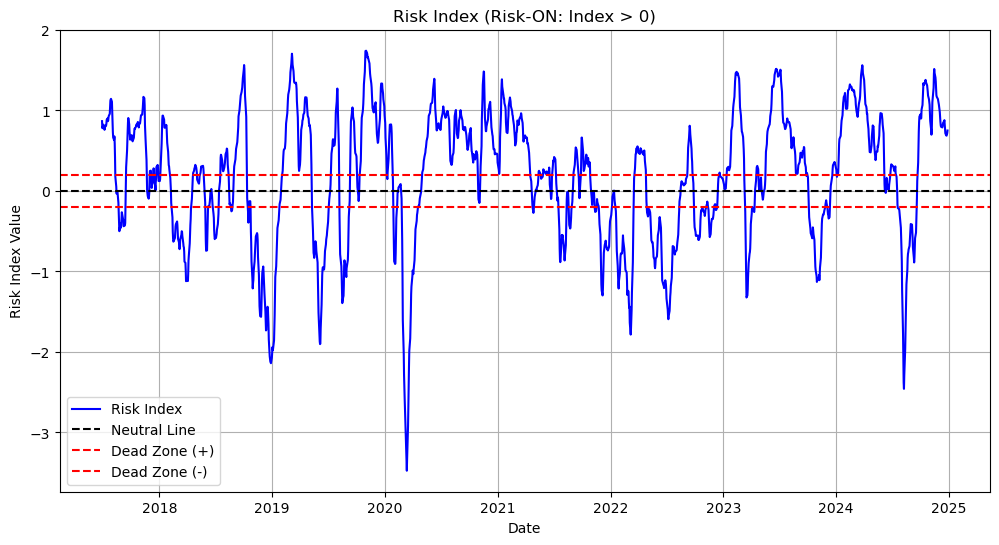

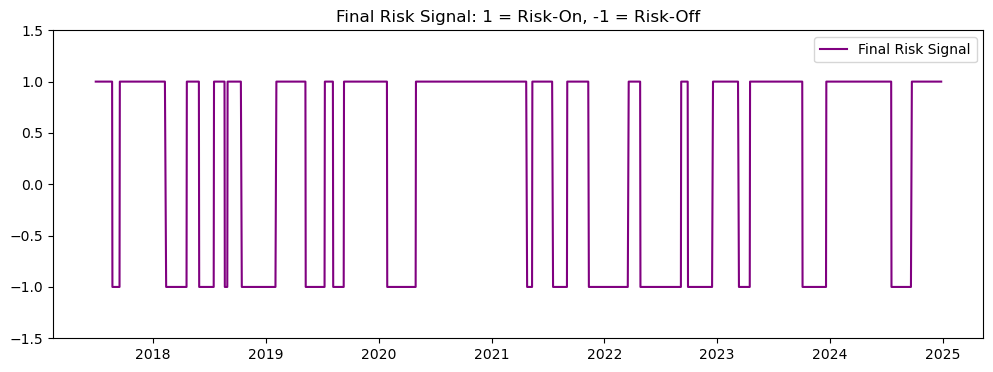

In [167]:
#FRED API키
api_key = "5ac724748f08e2b7210dde20f7880a42"

# Rolling Z-Scores for Each Indicator
window_long = 60

fred_codes = {
    "AAA_Yield": "BAMLC0A1CAAAEY",   # AAA 등급 회사채 금리
    "BBB_Yield": "BAMLC0A4CBBBEY",    # BBB 등급 회사채 금리
    "Yield_Curve": "T10Y2Y",          # 10년물 - 2년물 금리스프레드
    "DGS10": "DGS10"                 # 10년물 미국채 수익률
}
fred_data = web.DataReader(list(fred_codes.values()), "fred", start=start_date, end=end_date, api_key=api_key)

# 비어있는 데이터를 이전 값으로 채우기 (forward fill)
# fred_data = fred_data.ffill()

fred_data.columns = fred_codes.keys()


# 신용스프레드 계산 (BBB - AAA)
fred_data['Credit_Spread'] = fred_data['BBB_Yield'] - fred_data['AAA_Yield']

# ICE BofAML MOVE 지수를 사용 (티커 '^MOVE)
move = yf.download('^MOVE', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('MOVE')

# USD/JPY 데이터 ('JPY=X')
usd_jpy = yf.download('JPY=X', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('USDJPY')

# S&P500 데이터
sp500 = yf.download('^GSPC', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('SP500')


df_risk = pd.concat([fred_data[['Credit_Spread', 'Yield_Curve', 'DGS10']], move, usd_jpy, sp500], axis=1).dropna()
df_risk = df_risk.dropna()

# (1) 신용스프레드 z-점수: 스프레드가 높으면(즉, BBB - AAA가 크면) 리스크오프
df_risk['Credit_z'] = (df_risk['Credit_Spread'] - df_risk['Credit_Spread'].rolling(window_long).mean()) \
                      / df_risk['Credit_Spread'].rolling(window_long).std()

# (2) MOVE z-점수: MOVE 지수가 높으면(즉, 채권 변동성이 높으면) 리스크오프
df_risk['MOVE_z'] = (df_risk['MOVE'] - df_risk['MOVE'].rolling(window_long).mean()) \
                    / df_risk['MOVE'].rolling(window_long).std()

# (3) 10년물 금리 모멘텀: 10년물 금리의 일별 변화량을 측정하여, 급격한 금리 하락(안전자산 선호)을 리스크오프로 판단
Yield_ma = df_risk['DGS10'].rolling(window=window_long).mean()
df_risk['DGS10_diff'] = df_risk['DGS10'] - Yield_ma
df_risk['DGS10_change_z'] = (df_risk['DGS10_diff'] - df_risk['DGS10_diff'].rolling(window_long).mean()) \
                         / df_risk['DGS10_diff'].rolling(window_long).std()

# df_risk['DGS10_change'] = df_risk['DGS10'].diff()
# df_risk['DGS10_change_z'] = (df_risk['DGS10_change'] - df_risk['DGS10_change'].rolling(window_long).mean()) \
#                             / df_risk['DGS10_change'].rolling(window_long).std()
# 금리 하락(음의 변화)은 위험회피 상황이므로, -1을 곱해 높은 값이 리스크오프로 반영되도록 함.
df_risk['YieldMomentum_z'] = -1 * df_risk['DGS10_change_z']

# (4) USD/JPY 안전자산 지표  
# 위험 회피 시 투자자들이 안전자산인 엔을 선호하여 USD/JPY가 하락함 → 이동평균보다 낮으면 리스크오프로 판단
usd_jpy_ma = df_risk['USDJPY'].rolling(window=window_long).mean()
df_risk['USDJPY_MA_diff'] = df_risk['USDJPY'] - usd_jpy_ma
df_risk['USDJPY_MA_z'] = (df_risk['USDJPY_MA_diff'] - df_risk['USDJPY_MA_diff'].rolling(window_long).mean()) \
                         / df_risk['USDJPY_MA_diff'].rolling(window_long).std()
# USD/JPY가 이동평균보다 낮으면, USDJPY_MA_diff는 음수가 되고 이를 -1로 곱해 양수로 만들어 리스크오프 신호로 반영
df_risk['USDJPY_MA_z'] = -1 * df_risk['USDJPY_MA_z']

# (5) S&P500 지수 지표
df_risk['SP500_z'] = (df_risk['SP500'] - df_risk['SP500'].rolling(window_long).mean()) \
                    / df_risk['SP500'].rolling(window_long).std()

df_risk['SP500_z'] = -1 * df_risk['SP500_z']

# Construct the Composite Risk Indicator
# 가중치 설정 (신용 0.30, MOVE 0.25, 금리 모멘텀 0.25, USD/JPY 0.20)
w_credit = 0.20
w_move = 0.20
w_yield = 0.20
w_usdjpy = 0.20
w_sp500 = 0.20

df_risk['Composite'] = (w_credit * df_risk['Credit_z'] +
                        w_move * df_risk['MOVE_z'] +
                        w_yield * df_risk['YieldMomentum_z'] +
                        w_usdjpy * df_risk['USDJPY_MA_z'] +
                        w_sp500*df_risk['SP500_z'])
# 5일 단순 이동평균으로 스무딩
df_risk['Composite_Smoothed'] = df_risk['Composite'].rolling(window=5, min_periods=1).mean()

# Dead Zone 설정
dead_zone = 0.2

# 초기 신호: Composite 값이 양수면 리스크 오프(-1), 음수면 리스크 온(1)
df_risk['Raw_Signal'] = np.where(df_risk['Composite_Smoothed'] > 0, -1, 1)

# Dead Zone 내에서는 이전 신호 유지
final_signals = df_risk['Raw_Signal'].copy()
for i in range(1, len(final_signals)):
    if abs(df_risk['Composite_Smoothed'].iat[i]) < dead_zone:
        final_signals.iat[i] = final_signals.iat[i-1]

df_risk['Final_Signal'] = final_signals

# 최종 신호: 1 → 리스크온, -1 → 리스크오프
df_risk['Final_Signal'] = np.where(df_risk['Final_Signal'] >= 0, 1, -1)
df_risk = df_risk.dropna(subset=['Composite_Smoothed'])
# # 추가 스무딩: 3일 이동평균 후 재이산화
# df_risk['Signal_Smoothed'] = df_risk['Final_Signal'].rolling(window=3, min_periods=1).mean()
# df_risk['Final_Signal'] = np.where(df_risk['Signal_Smoothed'] > 0, 1, -1)

plt.figure(figsize=(12,6))
plt.plot(df_risk.index, -df_risk['Composite_Smoothed'], label='Risk Index', color='blue')
plt.axhline(0, color='black', linestyle='--', label="Neutral Line")  # 중립선 (0 기준선)
plt.axhline(dead_zone, color='red', linestyle='--', label="Dead Zone (+)")  # +Dead Zone
plt.axhline(-dead_zone, color='red', linestyle='--', label="Dead Zone (-)")  # -Dead Zone

plt.title("Risk Index (Risk-ON: Index > 0)")
plt.xlabel("Date")
plt.ylabel("Risk Index Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_risk.index, df_risk['Final_Signal'], label='Final Risk Signal', color='purple')
plt.title("Final Risk Signal: 1 = Risk-On, -1 = Risk-Off")
plt.ylim([-1.5, 1.5])
plt.legend()
plt.show()


In [168]:
df_risk[['Credit_z','MOVE_z','USDJPY_MA_z','YieldMomentum_z','Composite_Smoothed']]

,Credit_z,MOVE_z,USDJPY_MA_z,YieldMomentum_z,Composite_Smoothed
2017-06-29,0.293415,-0.560025,-1.340427,-2.061103,-0.866412
2017-06-30,1.393719,-0.469720,-1.081953,-2.552637,-0.778943
2017-07-03,0.861810,-0.445950,-1.182556,-2.911480,-0.823411
2017-07-05,1.417817,-0.267864,-1.533274,-2.440215,-0.806646
2017-07-06,1.417817,-0.173492,-1.583097,-2.745122,-0.778534
...,...,...,...,...,...
2024-12-20,-1.038738,-0.935033,-0.890382,-0.437399,-0.715917
2024-12-23,-1.009726,-0.692019,-0.501161,-0.729714,-0.688656
2024-12-24,-0.982232,-0.635476,-0.602351,-0.630722,-0.686290
2024-12-26,-0.956282,-0.747549,-0.506447,-0.463089,-0.716590


In [177]:
# (원래 주석: high_quality_etfs = ['AGG', 'LQD', 'IEF', 'TLT'], low_quality_etfs = ['HYG', 'JNK', 'EMB', 'HYD'])
high_quality_etfs = ['AGG']
low_quality_etfs  = ['QQQ']
etfs = high_quality_etfs + low_quality_etfs

price_data = yf.download(etfs, start=start_date, end=end_date, multi_level_index=False, progress=False)['Close']
price_data['HighQuality'] = price_data[high_quality_etfs].mean(axis=1)
price_data['LowQuality']  = price_data[low_quality_etfs].mean(axis=1)
price_data['HQ_Return']   = price_data['HighQuality'].pct_change()
price_data['LQ_Return']   = price_data['LowQuality'].pct_change()

# ================================================================
# 4) 전략용 데이터(df_strategy) 생성
#    - df_risk['Final_Signal']와 price_data를 병합
# ================================================================
df_strategy = price_data[['HQ_Return', 'LQ_Return']].join(df_risk[['Final_Signal']], how='inner')
df_strategy = df_strategy.dropna()

# pandas의 weekday는 월=0, 화=1, ... 일=6 이므로 화요일은 1입니다.
rebalance_days = df_strategy.index[df_strategy.index.weekday == 1]
rebalance_days = pd.to_datetime(rebalance_days)

# 6) weekly 신호 생성 + 2일 lag 적용 -> 화요일 정보를 가지고 목요일날 트레이딩
weekly_signal = df_strategy.loc[rebalance_days, 'Final_Signal']
df_strategy['Weekly_Signal'] = weekly_signal.reindex(df_strategy.index, method='ffill')
df_strategy['Signal'] = df_strategy['Weekly_Signal'].shift(2)
df_strategy = df_strategy.dropna(subset=['Signal'])

# # ================================================================
# # 5) 월별 리밸런싱 날짜 선정 (매월 23일 또는 그 이후 첫 거래일)
# # ================================================================
# rebalance_target_day = 23
# unique_months = df_strategy.index.to_period('M').unique()
# rebalance_days = []
# for period in unique_months:
#     target_date = period.to_timestamp() + pd.Timedelta(days=rebalance_target_day - 1)
#     trading_days_after = df_strategy.index[df_strategy.index >= target_date]
#     if not trading_days_after.empty:
#         rebalance_days.append(trading_days_after[0])
# rebalance_days = pd.to_datetime(rebalance_days)

# # ================================================================
# # 6) 월별 신호 생성 + 2일 lag 적용 (선견편향 방지)
# # ================================================================
# monthly_signal = df_strategy.loc[rebalance_days, 'Final_Signal']
# df_strategy['Monthly_Signal'] = monthly_signal.reindex(df_strategy.index, method='ffill')
# df_strategy['Signal'] = df_strategy['Monthly_Signal'].shift(2)
# df_strategy = df_strategy.dropna(subset=['Signal'])

# ================================================================
# 8) vectorbt 연결: 시그널에 따라 자산 매수/매도하는 전략 백테스트
# ================================================================
# 8-1) 시그널 -> 목표 비중(Weights) 변환
#     시그널이 -1이면 HighQuality 100%, 1이면 LowQuality 100%
# 동적 포지션 사이징 계산 (MOVE 기반)
# move = df_risk['MOVE'] 
# move_ma = move.rolling(window=30).mean()
# move_std = move.rolling(window=30).std()
# move_z = (move - move_ma) / move_std
# move_z = move_z.shift(1)
# scaling_factor_daily = np.where(move_z > 0.7, 0.3, 1.0)
# scaling_factor = pd.Series(scaling_factor_daily, index=move.index).reindex(df_strategy.index, method='ffill')

scaling_factor = 1.0

weights = pd.DataFrame(index=df_strategy.index, columns=['HighQuality', 'LowQuality'])
weights['HighQuality'] = np.where(df_strategy['Signal'] == -1, scaling_factor, 0.0)
weights['LowQuality']  = np.where(df_strategy['Signal'] ==  1, scaling_factor, 0.0)

# 8-2) target weights의 일별 변화량 -> 주문 수량 계산
#     (오늘의 목표 비중 - 전일 목표 비중) / 해당 자산 가격
# vectorbt에서 사용할 가격은 원래의 price_data에서 HighQuality, LowQuality 열을 선택합니다.
vecbt_prices = price_data[['HighQuality', 'LowQuality']].loc[df_strategy.index]
diff_weights = weights.diff().fillna(weights)
orders = diff_weights.div(vecbt_prices).fillna(0.0)

# 8-3) vectorbt 포트폴리오 생성
#     cash_sharing=True, group_by=[0,0]로 모든 자산이 하나의 자금풀을 공유하게 함
pf = vbt.Portfolio.from_orders(
    close=vecbt_prices,
    size=orders,
    init_cash=1.0,
    fees=tc_rate,
    freq='1D',
    cash_sharing=True,
    group_by=[0, 0]
)

print("Portfolio Statistics:")
print(f"Annualized Volatility:                             {pf.annualized_volatility():.2%}")
print(pf.stats())

# 8-4) 포트폴리오 결과 시각화
# 단일 포트폴리오의 가치 시계열 (에쿼티 커브)
pf.plot().show()

# 또는, 포트폴리오 가치와 누적 수익률을 직접 플롯
portfolio_value = pf.value()    # 시계열 데이터
portfolio_value.vbt.plot(title="Vectorbt Portfolio Value").show()

vec_cum_returns = (1 + pf.returns()).cumprod()
vec_cum_returns.vbt.plot(title="Vectorbt Cumulative Returns").show()
# 연환산 변동성 확인 (252 거래일 기준)


Portfolio Statistics:
Annualized Volatility:                             21.65%
Start                                 2017-01-12 00:00:00
End                                   2024-12-27 00:00:00
Period                                 1972 days 00:00:00
Start Value                                           1.0
End Value                                        4.259637
Total Return [%]                               325.963741
Benchmark Return [%]                           180.164262
Max Gross Exposure [%]                     2593564.458952
Total Fees Paid                                  0.191453
Max Drawdown [%]                                28.804225
Max Drawdown Duration                   390 days 00:00:00
Total Trades                                           34
Total Closed Trades                                    32
Total Open Trades                                       2
Open Trade PnL                                   1.316564
Win Rate [%]                                      

c:\Users\ghp04\.conda\envs\mfe311\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\ghp04\.conda\envs\mfe311\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



In [178]:
df_strategy['Weekly_Signal'].value_counts()

Weekly_Signal
 1.0    1268
-1.0     704
Name: count, dtype: int64

In [185]:
# 벤치마크 (QQQ Buy-and-Hold) 가격 데이터 가져오기
benchmark_close = yf.download("QQQ", start=start_date, end=end_date, progress=False)['Close']
benchmark_close = benchmark_close.reindex(vecbt_prices.index).ffill()

benchmark_pf = vbt.Portfolio.from_holding(
    close=benchmark_close,
    init_cash=1.0,  # 초기 자금 (전략과 동일한 기준)
    freq="1D"
)

benchmark_stats = benchmark_pf.stats()
filtered_benchmark_stats = benchmark_stats.dropna()  # NaN 제거

print("\nBenchmark (QQQ Buy-and-Hold) Statistics (Filtered):")
print(filtered_benchmark_stats)

# ================================
# 6) 포트폴리오 통계 출력 및 플롯
# ================================
print("\nStrategy Portfolio Statistics:")
print(pf.stats())

# 포트폴리오 에쿼티 커브 플롯
pf.plot().show()

# 포트폴리오 가치와 누적 수익률 직접 플롯
portfolio_value = pf.value()
portfolio_value.vbt.plot(title="Vectorbt Portfolio Value").show()

vec_cum_returns = (1 + pf.returns()).cumprod()
vec_cum_returns.vbt.plot(title="Vectorbt Cumulative Returns").show()

C:\Users\ghp04\AppData\Local\Temp\ipykernel_59548\2388236722.py:11: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001AAF5374B80>. Pass column to select a single column/group.

c:\Users\ghp04\.conda\envs\mfe311\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\ghp04\.conda\envs\mfe311\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data




Benchmark (QQQ Buy-and-Hold) Statistics (Filtered):
Start                     2017-01-12 00:00:00
End                       2024-12-27 00:00:00
Period                     1972 days 00:00:00
Start Value                               1.0
End Value                            4.504167
Total Return [%]                   350.416695
Benchmark Return [%]               350.416695
Max Gross Exposure [%]                  100.0
Total Fees Paid                           0.0
Max Drawdown [%]                    35.118726
Max Drawdown Duration       490 days 00:00:00
Total Trades                              1.0
Total Closed Trades                       0.0
Total Open Trades                         1.0
Open Trade PnL                       3.504167
Sharpe Ratio                         1.143993
Calmar Ratio                         0.914696
Omega Ratio                          1.188616
Sortino Ratio                        1.614444
Name: agg_func_mean, dtype: object

Strategy Portfolio Statistics:
Start 

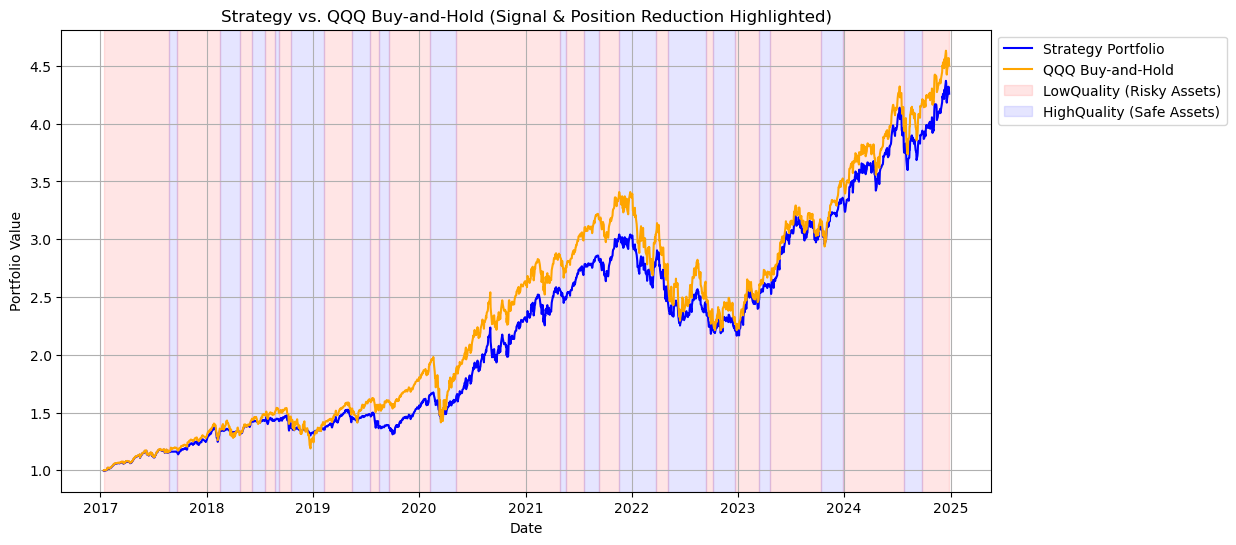

In [184]:
plt.figure(figsize=(12,6))

# 전략 및 벤치마크 포트폴리오 가치 시계열
portfolio_value = pf.value()
benchmark_value = benchmark_pf.value()

# 전략 포트폴리오 (파란색)
plt.plot(portfolio_value.index, portfolio_value, label="Strategy Portfolio", color='blue')

# 벤치마크 QQQ 바이앤홀드 (주황색)
plt.plot(benchmark_value.index, benchmark_value, label="QQQ Buy-and-Hold", color='orange')

# 시그널에 따른 색칠 (구간별로 배경색 다르게)
previous_signal = df_strategy['Risk_Signal'].iloc[0]
start_idx = df_strategy.index[0]

# 중복 방지용 (범례 추가 여부)
label_added = { -1: False, 1: False }

for i in range(1, len(df_strategy)):
    current_signal = df_strategy['Risk_Signal'].iloc[i]

    # 신호가 바뀌면 이전 구간 색칠
    if current_signal != previous_signal or i == len(df_strategy) - 1:
        end_idx = df_strategy.index[i]

        if previous_signal == -1 and not label_added[-1]:
            plt.axvspan(start_idx, end_idx, color='blue', alpha=0.1, label="HighQuality (Safe Assets)")
            label_added[-1] = True  # 한 번만 추가
        elif previous_signal == 1 and not label_added[1]:
            plt.axvspan(start_idx, end_idx, color='red', alpha=0.1, label="LowQuality (Risky Assets)")
            label_added[1] = True  # 한 번만 추가
        else:
            plt.axvspan(start_idx, end_idx, color='blue' if previous_signal == -1 else 'red', alpha=0.1)

        # 다음 구간 시작점 갱신
        start_idx = end_idx
        previous_signal = current_signal

# [2] 추가: MOVE 신호(포지션 축소) 구간 표시 (MOVE 신호가 -1이면 포지션 축소)
# df_strategy['Move_Signal']는 별도의 MOVE 신호입니다.
prev_move = df_strategy['Move_Signal'].iloc[0]
move_start_idx = df_strategy.index[0]
label_added_move = False
for i in range(1, len(df_strategy)):
    current_move = df_strategy['Move_Signal'].iloc[i]
    if current_move != prev_move or i == len(df_strategy) - 1:
        move_end_idx = df_strategy.index[i]
        if prev_move == -1:  # 포지션 축소 구간
            if not label_added_move:
                plt.axvspan(move_start_idx, move_end_idx, color='green', alpha=0.2, hatch='//', label="Position Reduction")
                label_added_move = True
            else:
                plt.axvspan(move_start_idx, move_end_idx, color='green', alpha=0.2, hatch='//')
        move_start_idx = move_end_idx
        prev_move = current_move

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Strategy vs. QQQ Buy-and-Hold (Signal & Position Reduction Highlighted)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [ ]:
df_strategy

,HQ_Return,LQ_Return,Final_Signal,Monthly_Signal,Signal
2007-09-26,-0.001001,0.004895,-1,-1.0,-1.0
2007-09-27,0.001705,0.005066,-1,-1.0,-1.0
2007-09-28,0.001502,-0.003296,-1,-1.0,-1.0
2007-10-01,-0.003373,0.011477,-1,-1.0,-1.0
2007-10-02,0.003828,0.000192,-1,-1.0,-1.0
...,...,...,...,...,...
2025-02-21,0.004303,-0.020755,1,1.0,1.0
2025-02-24,0.001734,-0.011804,1,1.0,1.0
2025-02-25,0.006212,-0.012599,-1,1.0,1.0
2025-02-26,0.001619,0.002416,-1,1.0,1.0


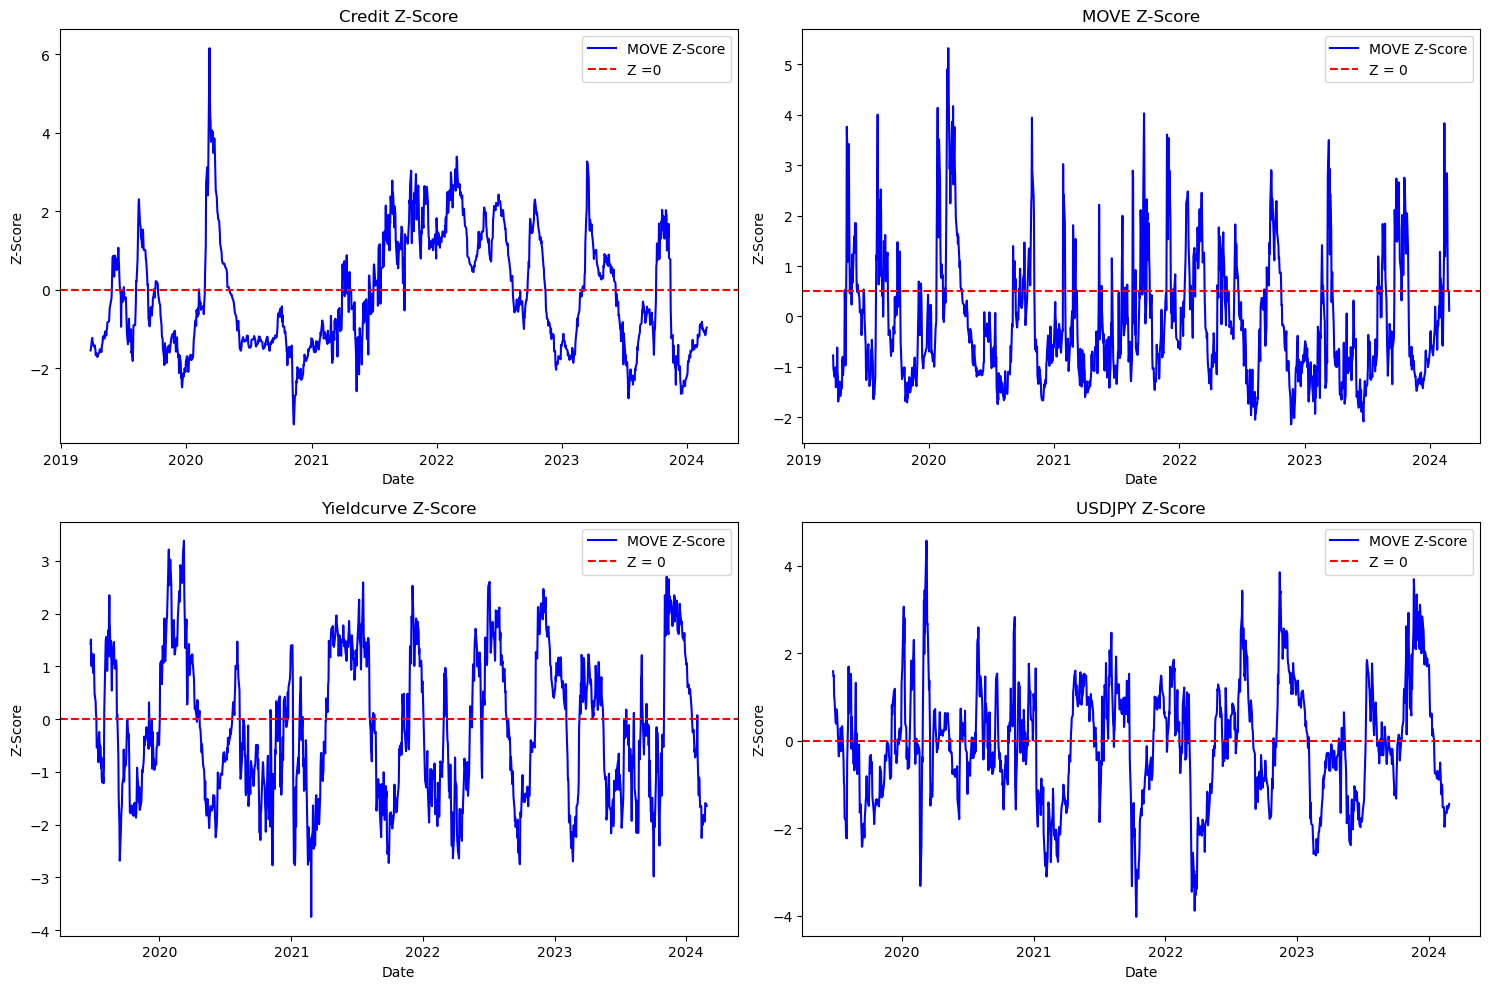

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# 1. MOVE Index (ICE BofAML MOVE)
axes[0].plot(df_risk.index, df_risk['Credit_z'], color='blue', label='MOVE Z-Score')
axes[0].axhline(0, color='red', linestyle='dashed', label='Z =0')  # Z-Score 1인 지점에 수평선 추가
axes[0].set_title('Credit Z-Score')
axes[0].set_ylabel('Z-Score')
axes[0].set_xlabel('Date')
axes[0].legend()

# 2. MOVE Z-Score
axes[1].plot(df_risk.index, df_risk['MOVE_z'], color='blue', label='MOVE Z-Score')
axes[1].axhline(0.5, color='red', linestyle='dashed', label='Z = 0')  # Z-Score 1인 지점에 수평선 추가
axes[1].set_title('MOVE Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()

# 3. 10Y-2Y Yield Curve Spread
axes[2].plot(df_risk.index, df_risk['YieldMomentum_z'], color='blue', label='MOVE Z-Score')
axes[2].axhline(0, color='red', linestyle='dashed', label='Z = 0')  # Z-Score 1인 지점에 수평선 추가
axes[2].set_title('Yieldcurve Z-Score')
axes[2].set_ylabel('Z-Score')
axes[2].set_xlabel('Date')
axes[2].legend()

# 4. 10-Year Treasury Yield (DGS10)
axes[3].plot(df_risk.index, df_risk['USDJPY_MA_z'], color='blue', label='MOVE Z-Score')
axes[3].axhline(0, color='red', linestyle='dashed', label='Z = 0')  # Z-Score 1인 지점에 수평선 추가
axes[3].set_title('USDJPY Z-Score')
axes[3].set_ylabel('Z-Score')
axes[3].set_xlabel('Date')
axes[3].legend()


# 전체 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

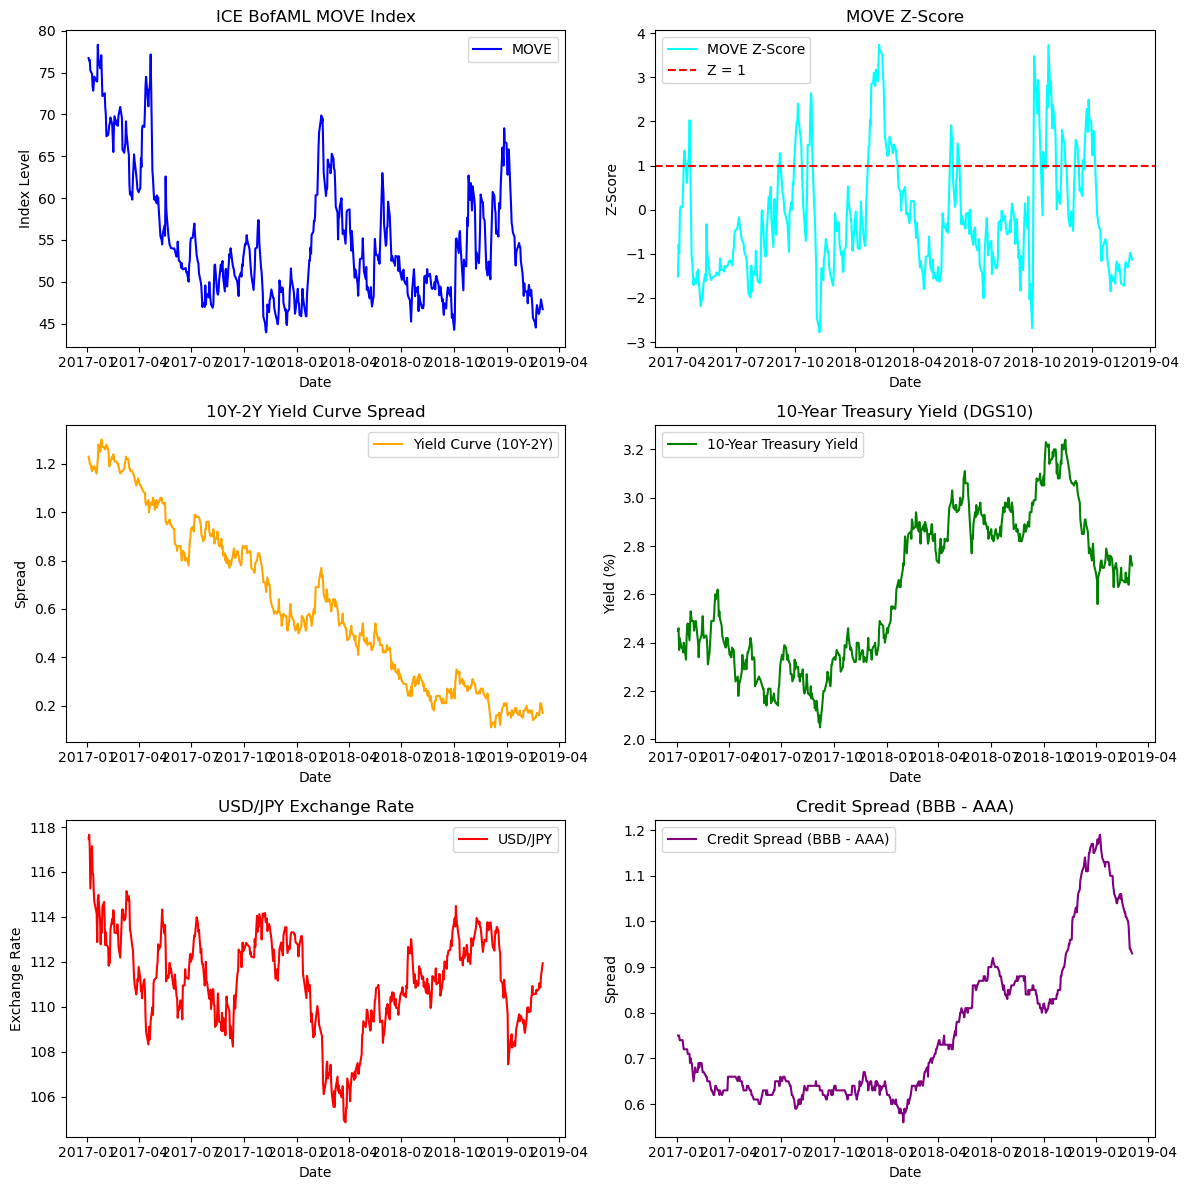

In [107]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

# 1. MOVE Index (ICE BofAML MOVE)
axes[0].plot(df_risk.index, df_risk['MOVE'], color='blue', label='MOVE')
axes[0].set_title('ICE BofAML MOVE Index')
axes[0].set_ylabel('Index Level')
axes[0].set_xlabel('Date')
axes[0].legend()

# 2. MOVE Z-Score
axes[1].plot(df_risk.index, df_risk['MOVE_z'], color='cyan', label='MOVE Z-Score')
axes[1].axhline(1, color='red', linestyle='dashed', label='Z = 1')  # Z-Score 1인 지점에 수평선 추가
axes[1].set_title('MOVE Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()

# 3. 10Y-2Y Yield Curve Spread
axes[2].plot(df_risk.index, df_risk['Yield_Curve'], color='orange', label='Yield Curve (10Y-2Y)')
axes[2].set_title('10Y-2Y Yield Curve Spread')
axes[2].set_ylabel('Spread')
axes[2].set_xlabel('Date')
axes[2].legend()

# 4. 10-Year Treasury Yield (DGS10)
axes[3].plot(df_risk.index, df_risk['DGS10'], color='green', label='10-Year Treasury Yield')
axes[3].set_title('10-Year Treasury Yield (DGS10)')
axes[3].set_ylabel('Yield (%)')
axes[3].set_xlabel('Date')
axes[3].legend()

# 5. USD/JPY Exchange Rate
axes[4].plot(df_risk.index, df_risk['USDJPY'], color='red', label='USD/JPY')
axes[4].set_title('USD/JPY Exchange Rate')
axes[4].set_ylabel('Exchange Rate')
axes[4].set_xlabel('Date')
axes[4].legend()

# 6. Credit Spread (BBB - AAA)
axes[5].plot(df_risk.index, df_risk['Credit_Spread'], color='purple', label='Credit Spread (BBB - AAA)')
axes[5].set_title('Credit Spread (BBB - AAA)')
axes[5].set_ylabel('Spread')
axes[5].set_xlabel('Date')
axes[5].legend()

# 전체 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

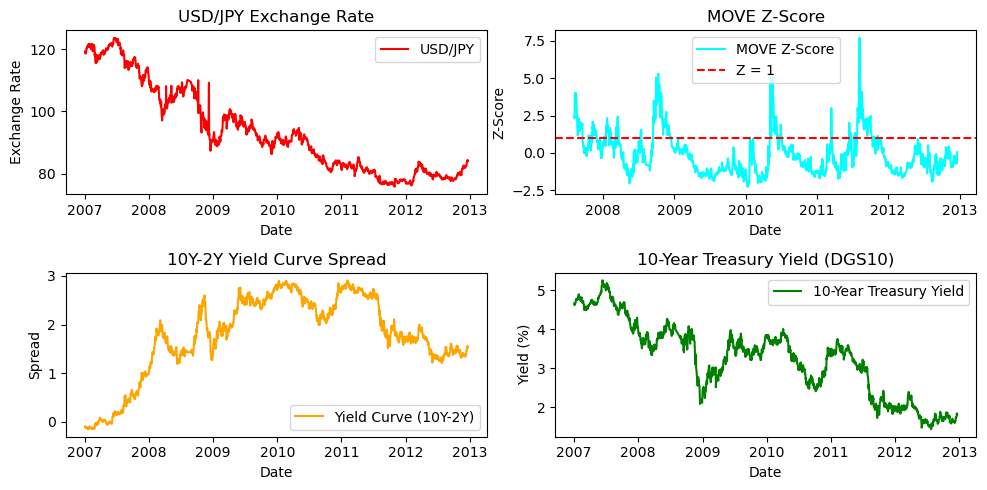

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flatten()

# 5. USD/JPY Exchange Rate
axes[0].plot(df_risk.index, df_risk['USDJPY'], color='red', label='USD/JPY')
axes[0].set_title('USD/JPY Exchange Rate')
axes[0].set_ylabel('Exchange Rate')
axes[0].set_xlabel('Date')
axes[0].legend()

# 2. MOVE Z-Score
axes[1].plot(df_risk.index, df_risk['MOVE_z'], color='cyan', label='MOVE Z-Score')
axes[1].axhline(1, color='red', linestyle='dashed', label='Z = 1')  # Z-Score 1인 지점에 수평선 추가
axes[1].set_title('MOVE Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()

# 3. 10Y-2Y Yield Curve Spread
axes[2].plot(df_risk.index, df_risk['Yield_Curve'], color='orange', label='Yield Curve (10Y-2Y)')
axes[2].set_title('10Y-2Y Yield Curve Spread')
axes[2].set_ylabel('Spread')
axes[2].set_xlabel('Date')
axes[2].legend()

# 4. 10-Year Treasury Yield (DGS10)
axes[3].plot(df_risk.index, df_risk['DGS10'], color='green', label='10-Year Treasury Yield')
axes[3].set_title('10-Year Treasury Yield (DGS10)')
axes[3].set_ylabel('Yield (%)')
axes[3].set_xlabel('Date')
axes[3].legend()



# 전체 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

### Index 정상성 테스트

In [8]:
from statsmodels.tsa.stattools import adfuller

# Composite_Smoothed 시계열의 정상성 검정
adf_result = adfuller(df_risk['Composite_Smoothed'].dropna())

print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
print("Number of Lags Used: {}".format(adf_result[2]))
print("Number of Observations Used: {}".format(adf_result[3]))
print("Critical Values:")
for key, value in adf_result[4].items():
    print("   {}: {:.4f}".format(key, value))

if adf_result[1] < 0.05:
    print("p-value가 0.05 미만입니다. 귀무가설(단위근, 즉 비정상성)을 기각하므로, 시계열은 정상성을 가진다고 볼 수 있습니다.")
else:
    print("p-value가 0.05 이상입니다. 귀무가설(단위근, 즉 비정상성)을 기각할 수 없으므로, 시계열은 정상성을 가지지 않는다고 볼 수 있습니다.")

ADF Statistic: -6.5786
p-value: 0.0000
Number of Lags Used: 31
Number of Observations Used: 4177
Critical Values:
   1%: -3.4319
   5%: -2.8622
   10%: -2.5671
p-value가 0.05 미만입니다. 귀무가설(단위근, 즉 비정상성)을 기각하므로, 시계열은 정상성을 가진다고 볼 수 있습니다.


### 주문 지시
- 2일의 lagging이 있음 (2월 13일자 기준으로 2월 11일까지의 데이터만 갖고있음)

In [48]:
start_date = "2019-01-01"
# 오늘 날짜를 자동으로 사용 (혹은 end_date를 원하는 날짜로 설정)
end_date = datetime.today().strftime('%Y-%m-%d')
# end_date = "2025-02-11"

api_key = "5ac724748f08e2b7210dde20f7880a42"

# --- 데이터 다운로드 ---
fred_codes = {
    "AAA_Yield": "BAMLC0A1CAAAEY",   # AAA 등급 회사채 금리
    "BBB_Yield": "BAMLC0A4CBBBEY",    # BBB 등급 회사채 금리
    "Yield_Curve": "T10Y2Y",          # 10년물 - 2년물 금리스프레드
    "DGS10": "DGS10"                 # 10년물 미국채 수익률
}
fred_data = web.DataReader(list(fred_codes.values()), "fred", start=start_date, end=end_date, api_key=api_key)

# 비어있는 데이터를 이전 값으로 채우기 (forward fill)
fred_data = fred_data.ffill()
fred_data.columns = fred_codes.keys()

fred_data['Credit_Spread'] = fred_data['BBB_Yield'] - fred_data['AAA_Yield']

# ICE BofAML MOVE 지수를 사용 (티커 '^MOVE)
move = yf.download('^MOVE', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('MOVE')

# USD/JPY 데이터 ('JPY=X')
usd_jpy = yf.download('JPY=X', start=start_date, end=end_date, multi_level_index=False)['Close'].rename('USDJPY')

# 데이터 병합
df = pd.concat([fred_data[['Credit_Spread', 'Yield_Curve', 'DGS10']], move, usd_jpy], axis=1)
df = df.dropna()

# --- 지표 계산 ---
window_long = 60

# (1) 신용스프레드 z-점수: 스프레드가 높으면 리스크오프
df['Credit_z'] = (df['Credit_Spread'] - df['Credit_Spread'].rolling(window_long).mean()) \
                 / df['Credit_Spread'].rolling(window_long).std()

# (2) MOVE z-점수: MOVE 지수가 높으면 채권 변동성이 높아 리스크오프
df['MOVE_z'] = (df['MOVE'] - df['MOVE'].rolling(window_long).mean()) \
               / df['MOVE'].rolling(window_long).std()

# (3) 10년물 금리 모멘텀: 10년물 금리의 일별 변화량 기반 – 금리 급락은 안전자산 선호 (리스크오프)
Yield_ma = df['DGS10'].rolling(window=window_long).mean()
df['DGS10_diff'] = df['DGS10'] - Yield_ma
df['DGS10_change_z'] = (df['DGS10_diff'] - df['DGS10_diff'].rolling(window_long).mean()) \
                         / df['DGS10_diff'].rolling(window_long).std()
df['YieldMomentum_z'] = -1 * df['DGS10_change_z']

# (4) USD/JPY 안전자산 지표: USD/JPY가 이동평균보다 낮으면 (즉, 엔 강세) 리스크오프
usd_jpy_ma = df['USDJPY'].rolling(window=window_long).mean()
df['USDJPY_MA_diff'] = df['USDJPY'] - usd_jpy_ma
df['USDJPY_MA_z'] = (df['USDJPY_MA_diff'] - df['USDJPY_MA_diff'].rolling(window_long).mean()) \
                    / df['USDJPY_MA_diff'].rolling(window_long).std()
df['USDJPY_MA_z'] = -1 * df['USDJPY_MA_z']

# --- Composite Risk Index ---
# 가중치 설정: 신용 0.30, MOVE 0.25, 금리 모멘텀 0.25, USD/JPY 0.20
w_credit = 0.30
w_move = 0.25
w_yield = 0.25
w_usdjpy = 0.20

df['Composite'] = (w_credit * df['Credit_z'] +
                   w_move * df['MOVE_z'] +
                   w_yield * df['YieldMomentum_z'] +
                   w_usdjpy * df['USDJPY_MA_z'])
# 5일 단순 이동평균으로 스무딩
df['Composite_Smoothed'] = df['Composite'].rolling(window=5, min_periods=1).mean()

# --- Trading Signal 생성 ---
# dead_zone 설정
dead_zone = 0.2
# 초기 신호: Composite 값이 양수면 리스크오프(-1), 음수면 리스크온(1)
df['Raw_Signal'] = np.where(df['Composite_Smoothed'] > 0, -1, 1)

# dead zone 내에서는 이전 신호 유지
final_signals = df['Raw_Signal'].copy()
for i in range(1, len(final_signals)):
    if abs(df['Composite_Smoothed'].iat[i]) < dead_zone:
        final_signals.iat[i] = final_signals.iat[i-1]
df['Final_Signal'] = final_signals

# 최종 신호: 1이면 Risk-On, -1이면 Risk-Off
df['Final_Signal'] = np.where(df['Final_Signal'] > 0, 1, -1)

# --- 오늘(최신 거래일)의 신호 및 Scaling Factor 계산 ---
latest_signal = df['Final_Signal'].iloc[-1]

# 동적 포지션 사이징 (MOVE 기반)
move_latest = df['MOVE'].iloc[-1]
move_ma_latest = df['MOVE'].rolling(window=30).mean().iloc[-1]
move_std_latest = df['MOVE'].rolling(window=30).std().iloc[-1]
move_z_latest = (move_latest - move_ma_latest) / move_std_latest
# 예시: MOVE z-점수가 1 이상이면 포지션 축소 → scaling factor = 0.4, 그렇지 않으면 1.0
scaling_factor = 0.3 if move_z_latest > 1.0 else 1.0

# --- 투자 집행 지시 결정 ---
# - scaling factor가 1보다 작으면: "Reduce position"
# - 그렇지 않으면, 신호가 1이면 "Buy Risky asset", 신호가 -1이면 "Buy High quality Bond"
if scaling_factor < 1.0:
    instruction = "Reduce position"
elif latest_signal == 1:
    instruction = "Buy Risky asset"
elif latest_signal == -1:
    instruction = "Buy High quality Bond"
else:
    instruction = "No Action"

# --- 결과 출력 ---
latest_date = df.index[-1].strftime('%Y-%m-%d')
print("Today's Date:", latest_date)
print("Today's Signal:", latest_signal)
print("Today's Scaling Factor:", scaling_factor)
print("Investment Instruction:", instruction)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Today's Date: 2025-02-28
Today's Signal: -1
Today's Scaling Factor: 0.3
Investment Instruction: Reduce position


### 일별로 신호를 계산했을때

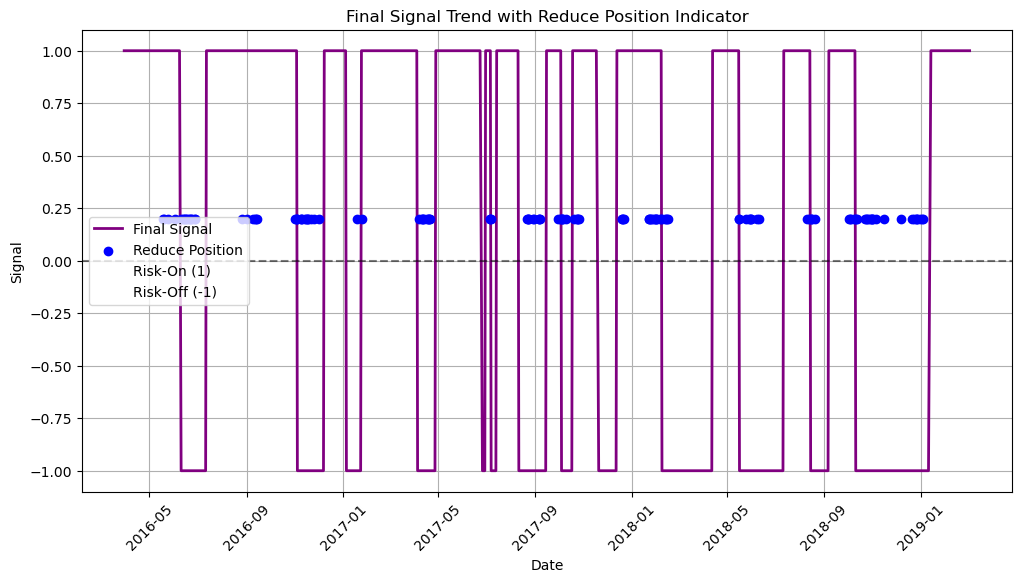

In [119]:
plt.figure(figsize=(12, 6))

# Final Signal 그래프
plt.plot(df_risk.index, df_risk['Final_Signal'], label='Final Signal', color='purple', linewidth=2)

# Reduce Position 신호가 발생한 시점을 파란색 점으로 표시
reduce_pos_dates = df_risk[df_risk['MOVE_z'] > 1.0].index  # MOVE Z-Score가 1 초과할 때 포지션 축소
plt.scatter(reduce_pos_dates, [0.2] * len(reduce_pos_dates), color='blue', label='Reduce Position', zorder=3)

# 기준선 추가
plt.axhline(y=1, color='white', linestyle='', label="Risk-On (1)")
plt.axhline(y=-1, color='white', linestyle='', label="Risk-Off (-1)")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# X축 포맷 설정 (3, 6, 9, 12월만 표시)
plt.xticks(rotation=45)

plt.title("Final Signal Trend with Reduce Position Indicator")
plt.xlabel("Date")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()


### 월별로 신호를 계산했을떄

C:\Users\ghp04\AppData\Local\Temp\ipykernel_6532\873717081.py:5: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df_strategy.index[reduce_mask], df_strategy['Signal'][reduce_mask],


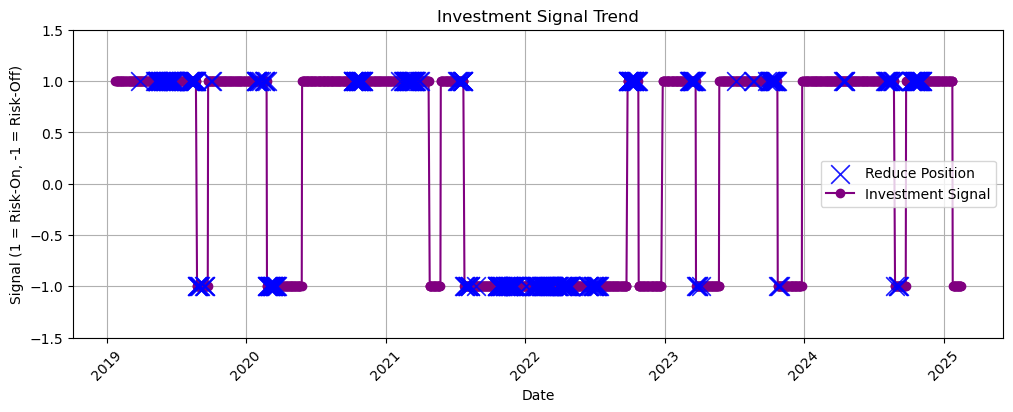

In [9]:
plt.figure(figsize=(12,4))

# Reduce Position 먼저 그리기 (보라색 선보다 위쪽에 오도록 설정)
reduce_mask = df_strategy['Scaling_Factor'] < 1.0
plt.scatter(df_strategy.index[reduce_mask], df_strategy['Signal'][reduce_mask], 
            color='blue', marker='x', s=180, label='Reduce Position', 
            alpha=0.9, edgecolors='black', linewidths=1.2, zorder=3)  # zorder를 3으로 높여 맨 위에 표시

# 기본 투자 시그널 선 (Risk-On: 1, Risk-Off: -1)
plt.plot(df_strategy.index, df_strategy['Signal'], label='Investment Signal', 
         color='purple', marker='o', linestyle='-', markersize=6, linewidth=1.5, zorder=2)  # zorder를 2로 설정하여 X마커 아래에 위치

# # x축 날짜 포맷 설정: 3월, 6월, 9월, 12월만 표시
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[3, 6, 9, 12]))  # 3, 6, 9, 12월에만 눈금 표시
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연도-월 형식으로 표시
plt.xticks(rotation=45)  

plt.title("Investment Signal Trend")
plt.xlabel("Date")
plt.ylabel("Signal (1 = Risk-On, -1 = Risk-Off)")
plt.ylim([-1.5, 1.5])
plt.legend()
plt.grid(True)
plt.show()